In [1]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import metrics, preprocessing

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from pyDeepInsight import ImageTransformer, LogScaler
from keras.callbacks import EarlyStopping

import pickle, joblib

2023-12-16 00:49:31.540750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('PortStatsfile.csv')

In [3]:
df.head()

,timestamp,datapath,rx-pkts,rx-bytes,rx-error,rx_dropped,tx-pkts,tx-bytes,tx-error,tx_dropped,duration_nsec,label
0,1.702158e+09,10,9,822,0,0,131,16582,0,0,4,0
1,1.702158e+09,10,11,942,0,0,128,16352,0,0,4,0
2,1.702158e+09,10,120,15122,0,0,19,2328,0,0,4,0
3,1.702158e+09,10,0,0,0,112,0,0,0,0,4,0
4,1.702158e+09,2,109,13786,0,0,36,4566,0,0,3,0


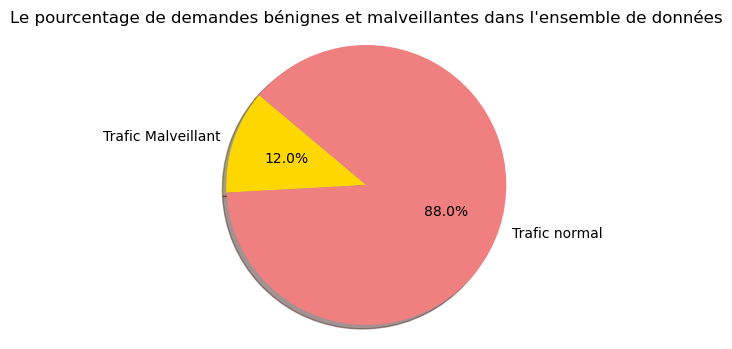

In [5]:
labels = ("Trafic Malveillant", "Trafic normal")
sizes = [len(df[df["label"]== 1]), len(df[df["label"]== 0])]

colors = ['gold', 'lightcoral']

plt.figure(figsize=(8, 4))
plt.title("Le pourcentage de demandes bénignes et malveillantes dans l'ensemble de données")
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.savefig("Pourcentage_bénignes_&_malveillantes")

In [6]:
df.label.value_counts()

0    28885
1     3932
Name: label, dtype: int64

In [4]:
df.dropna(inplace=True)
df.drop(['timestamp','datapath'], axis=1, inplace=True)

In [6]:
scaler = preprocessing.MinMaxScaler()
df_nrm= scaler.fit_transform(df)
df_nv = pd.DataFrame(df_nrm, columns=df.columns)
df_nv.head()

,rx-pkts,rx-bytes,rx-error,rx_dropped,tx-pkts,tx-bytes,tx-error,tx_dropped,duration_nsec,label
0,3.174885e-07,8.480693e-10,0.0,0.000000,4.621222e-06,1.710789e-08,0.0,0.0,0.001521,0.0
1,3.880415e-07,9.718750e-10,0.0,0.000000,4.515392e-06,1.687059e-08,0.0,0.0,0.001521,0.0
2,4.233180e-06,1.560159e-08,0.0,0.000000,6.702535e-07,2.401831e-09,0.0,0.0,0.001521,0.0
3,0.000000e+00,0.000000e+00,0.0,0.022825,0.000000e+00,0.000000e+00,0.0,0.0,0.001521,0.0
4,3.845139e-06,1.422322e-08,0.0,0.000000,1.269954e-06,4.710808e-09,0.0,0.0,0.001141,0.0


In [8]:
X = df_nv.drop('label', axis=1).astype(float)
y = df_nv['label']

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
start_time = time.time()

# GridSearchCV pour trouver les meilleurs hyperparamètres
knnc = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knnc_search = GridSearchCV(knnc, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)
knnc_search.fit(X_train, y_train)

best_params = knnc_search.best_params_
n_neighbors = best_params['n_neighbors']
weights = best_params['weights']
metric = best_params['metric']

# Utilisation des meilleurs hyperparamètres sur l'ensemble d'entraînement
KNN = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
KNN.fit(X_train, y_train)

# Prédiction et évaluation sur l'ensemble de validation
predicted_val = KNN.predict(X_val)
accuracy_val = accuracy_score(y_val, predicted_val)
print(f"Précision sur l'ensemble de validation : {round(accuracy_val * 100, 2)}%")

# Prédiction et évaluation sur l'ensemble de test
predicted_test = KNN.predict(X_test)
accuracy_test = accuracy_score(y_test, predicted_test)
print(f"Précision sur l'ensemble de test : {round(accuracy_test * 100, 2)}%")

# Affichage des résultats finaux
print("Meilleurs hyperparamètres:", best_params)
print(classification_report(predicted_test, y_test))
print("--- %s secondes --- temps pour le modèle KNN " % (time.time() - start_time))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Précision sur l'ensemble de validation : 93.58%
Précision sur l'ensemble de test : 94.37%
Meilleurs hyperparamètres: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4361
         1.0       0.74      0.78      0.76       562

    accuracy                           0.94      4923
   macro avg       0.86      0.87      0.86      4923
weighted avg       0.94      0.94      0.94      4923

--- 5.171551465988159 secondes --- temps pour le modèle KNN 
